In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import math
# Dataset Class
class SpeedDataset(Dataset):
    def __init__(self, directory, sequence_length=5):
        self.data = []
        self.sequence_length = sequence_length
        self.preprocess_data(directory)

    def preprocess_data(self, directory):
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                speed = float(filename.split('_')[-1].replace('.txt', ''))
                filepath = os.path.join(directory, filename)
                with open(filepath, 'r') as file:
                    track_data = {}
                    for line in file:
                        frame, track_id, x1, y1, x2, y2 = map(float, line.strip().split(',')[:6])
                        if track_id not in track_data:
                            track_data[track_id] = []
                        track_data[track_id].append([x1,y1,x2,y2,(x1+x2)/2, (y1+y2)/2, (x1-x2),(y1-y2)])

                    for track_id, frames in track_data.items():
                        if len(frames) >= self.sequence_length:
                            features = []
                            for i in range(1, len(frames)):
                                current_frame = frames[i]
                                previous_frame = frames[i-1]
                                data_d = []
                                distance = 0
                                distance1 = 0
                                distance2 = 0
                                for i in range(4):
                                    data_d.append(( current_frame[i])/1000)
                                for i in range(4):
                                    data_d.append(abs(current_frame[i] - previous_frame[i]))
                                for j in range(4,6):
                                    distance = ((current_frame[j] - previous_frame[j])**2) + distance
                                for j in range(0,2):
                                    distance1 = ((current_frame[j] - previous_frame[j])**2) + distance1
                                for j in range(2,4):
                                    distance2 = ((current_frame[j] - previous_frame[j])**2) + distance2
                                
                                data_d.append(math.sqrt(distance/0.03))
                                data_d.append(math.sqrt(distance1/0.03))
                                data_d.append(math.sqrt(distance2/0.03))
                                data_d.append(abs(current_frame[6]))
                                data_d.append(abs(current_frame[7]))
                                data_d.append(abs(current_frame[6] *current_frame[7]))
                                for i in range(4):
                                    data_d.append(( previous_frame[i])/1000)
                                features.append(data_d)
                            num_sequences = len(features) // self.sequence_length
                            for i in range(num_sequences):
                                start_idx = i * self.sequence_length
                                end_idx = start_idx + self.sequence_length
                                sequence = features[start_idx:end_idx]
                                self.data.append((sequence, speed))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs, output = self.data[idx]
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(output, dtype=torch.float32)

In [2]:
import torch

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        scores = self.attention(x).squeeze(2) 
        alpha = F.softmax(scores, dim=1).unsqueeze(2)  
        context = (x * alpha).sum(dim=1)
        return context, alpha


In [13]:
class SpeedPredictor(nn.Module):
    def __init__(self, sequence_length, feature_size, embedding_dim, hidden_dim, output_size):
        super(SpeedPredictor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=feature_size, out_channels=hidden_dim, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=5, dropout=0.2)
        self.attention = Attention(hidden_dim)
        self.conv3 = nn.Conv1d(in_channels=hidden_dim, out_channels=64, kernel_size=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  
        x = self.conv1(x)
        #x = self.conv2(x)
        x = self.bn1(x)
        x = x.permute(0, 2, 1) 
        x, _ = self.lstm(x)
        x, attn_weights = self.attention(x)  
        x = x.unsqueeze(2)  
        x = self.conv3(x)
        #x = self.conv4(x)
        #x = self.bn2(x)
        x = x.squeeze(2)  
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
def init_weights(m):
    if type(m) == nn.LSTM:
        torch.nn.init.xavier_uniform_(m.weight_ih_l0)
        torch.nn.init.orthogonal_(m.weight_hh_l0)
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)


In [14]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer,scheduler, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        for inputs, speeds in train_loader:
            inputs, speeds = inputs.to(device), speeds.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze() 
            if outputs.shape != speeds.shape:
                outputs = outputs[:speeds.size(0)]  
            loss = criterion(outputs, speeds)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, speeds in val_loader:
                inputs, speeds= inputs.to(device), speeds.to(device)
                outputs = model(inputs)
                outputs = outputs.squeeze()  
                if outputs.shape != speeds.shape:
                    outputs = outputs[:speeds.size(0)]  
                loss = torch.sqrt(criterion(outputs, speeds))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        if epoch % 10 ==0:
            print(f'Epoch {epoch+1}/{epochs}, MSE training Loss: {avg_train_loss:.4f}, RMSE validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


In [15]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

full_dataset = SpeedDataset('outputs', sequence_length=15)  
val_size = int(0.1 * len(full_dataset))  
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(len(train_dataset))

1979


In [17]:
# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeedPredictor(sequence_length=15, feature_size=18, embedding_dim=64, hidden_dim=128, output_size=1)
model.to(device)
model.apply(init_weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Scheduler for learning rate adjustment
scheduler = ExponentialLR(optimizer, gamma=0.9892)
train_losses,val_losses = train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=300)

Epoch 1/300, MSE training Loss: 987.5736, RMSE validation Loss: 21.2711
Epoch 11/300, MSE training Loss: 640.2448, RMSE validation Loss: 20.9774
Epoch 21/300, MSE training Loss: 604.8067, RMSE validation Loss: 21.0693
Epoch 31/300, MSE training Loss: 604.5802, RMSE validation Loss: 21.4735
Epoch 41/300, MSE training Loss: 569.7089, RMSE validation Loss: 21.0145
Epoch 51/300, MSE training Loss: 533.9159, RMSE validation Loss: 20.7322
Epoch 61/300, MSE training Loss: 525.2202, RMSE validation Loss: 20.9849
Epoch 71/300, MSE training Loss: 534.4094, RMSE validation Loss: 20.7913
Epoch 81/300, MSE training Loss: 499.2972, RMSE validation Loss: 20.3254
Epoch 91/300, MSE training Loss: 493.5455, RMSE validation Loss: 20.3927
Epoch 101/300, MSE training Loss: 458.7255, RMSE validation Loss: 19.3876
Epoch 111/300, MSE training Loss: 429.7277, RMSE validation Loss: 19.3863
Epoch 121/300, MSE training Loss: 403.4225, RMSE validation Loss: 17.8623
Epoch 131/300, MSE training Loss: 354.8877, RMSE 

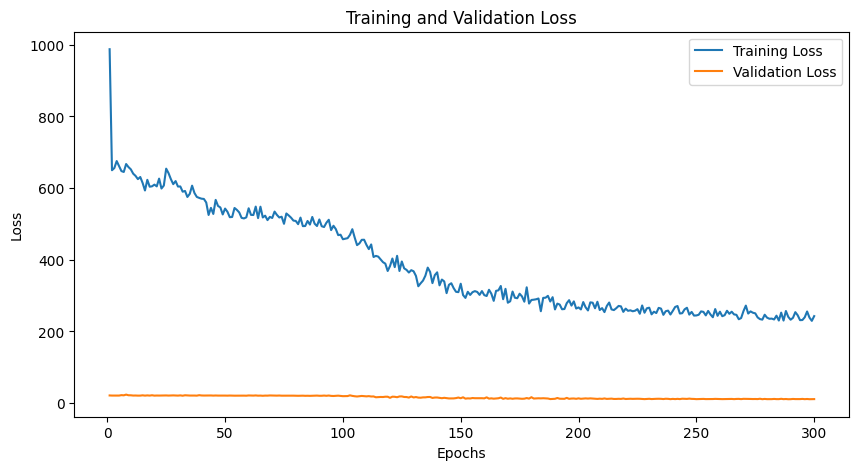

In [18]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 300+1), train_losses, label='Training Loss')
plt.plot(range(1, 300+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [19]:

torch.save(model, 'NO_lstm_Regression_150.pth')


In [20]:
# Load the entire model
model = torch.load('NO_lstm_Regression_150.pth').to(device)
model.eval()  # Set the model to evaluation mode


SpeedPredictor(
  (conv1): Conv1d(18, 128, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(128, 128, num_layers=5, batch_first=True, dropout=0.2)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=True)
  )
  (conv3): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (conv4): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [21]:
import random
def predict_and_compare(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    predictions = []
    actuals = []
    total_loss = 0
    with torch.no_grad():  # No need to track gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.tolist())  
            loss = torch.sqrt(criterion(outputs, targets))
            if outputs.shape != targets.shape:
                outputs = outputs[:targets.size(0)] 
            total_loss += loss.item()
    return predictions, actuals, total_loss/len(test_loader)

test_dataset = SpeedDataset('test_outputs', sequence_length=15)  
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
predictions, actuals, loss = predict_and_compare(model, test_loader)

def print_random_predictions(predictions, actuals, num_samples=30):
    if len(predictions) < num_samples:
        num_samples = len(predictions)  # Adjust sample size if predictions are fewer than requested

    # Get random sample indices
    sample_indices = random.sample(range(len(predictions)), num_samples)

    # Print the randomly selected predictions and their actual values
    for idx in sample_indices:
        print(f"Predicted: {predictions[idx]:.4f}, Actual: {actuals[idx]:.4f}")

# Assuming you have already executed the predict_and_compare function
# predictions, actuals = predict_and_compare(model, val_loader)

# Now print randomly selected 30 predictions and their actual values
print_random_predictions(predictions, actuals, 50)
print(loss)


Predicted: 77.4486, Actual: 80.0000
Predicted: 64.0402, Actual: 46.0000
Predicted: 31.4726, Actual: 35.0000
Predicted: 37.2952, Actual: 50.0000
Predicted: 41.5230, Actual: 48.0000
Predicted: 45.5612, Actual: 42.0000
Predicted: 70.8918, Actual: 84.0000
Predicted: 87.1060, Actual: 94.0000
Predicted: 53.6697, Actual: 44.0000
Predicted: 77.9293, Actual: 66.0000
Predicted: 68.6562, Actual: 74.0000
Predicted: 81.0966, Actual: 91.0000
Predicted: 71.2255, Actual: 77.0000
Predicted: 53.1717, Actual: 52.0000
Predicted: 37.1321, Actual: 38.0000
Predicted: 35.2826, Actual: 35.0000
Predicted: 90.9985, Actual: 94.0000
Predicted: 89.1365, Actual: 95.0000
Predicted: 33.8849, Actual: 35.0000
Predicted: 54.5528, Actual: 64.0000
Predicted: 81.1526, Actual: 90.0000
Predicted: 48.8171, Actual: 60.0000
Predicted: 54.4753, Actual: 62.0000
Predicted: 78.7257, Actual: 98.0000
Predicted: 37.2663, Actual: 46.0000
Predicted: 62.4837, Actual: 44.0000
Predicted: 37.7658, Actual: 48.0000
Predicted: 76.5927, Actual: 